# Final Project Write Up - SlattBot
##### Payton Burks

### Summary
Slattbot was a somewhat successful attempt at exploring AI and human response to different positive, negative, and neutral sentiment at varying levels of intensity. 

My initial scope included these goals:
* Train multiple AI models on tweets from musical artists with ‘cult-like’ followings
* Build a responsive community of these AI on Twitter
* See how positive/negative sentiment affect the sentiment and likelihood of reply
     * Both AI and human responses
* Predict reply count, sentiment based on tweet 

However, several challenges limited the progress and full completion of the goals. I will address these shortcomings as they appear in the write-up.

### Research Proposal
Originally I wanted to use smash bros tournament data to predict seeding upsets. I wanted to build a webscraper and subsequently store my data in Google Cloud Platform. Thus, much of my research was dedicated to learning GCP, which I did eventually use for much of my data storage. I also wanted to use pytorch to make the model for the predictions, but I pivoted to tensorflow instead. 

I spent much of this time figuring out the tensorflow basics and decided I wanted to do text generation for my tutorial. I based much of my work off of the tensorflow [website](https://www.tensorflow.org/text/tutorials/text_generation)

### Project Proposal
Here is where I fully put down my goals and what I wanted to achieve in the project. I wanted to...

* Create generative text bots that output tweets on a (daily?) schedule
* Make them interact in a community-like setting
* Reply based on probablity of interaction
* Allow bots to like and rt 
* Visualize interaction over time

I think one of my biggest challenges was defining the overall scope of the project at this point. There is a lot of ideas here, but it is less-so data focused and doesn't really have any measurable goals.

### Tech stack
I decided to use
* SNScrape - get historical data
* GCP (cloud scheduler - publishing tweets, big query - storing new data)
* tweepy - get new data, manipulate bots

I decided that I wanted to retrain the model offline with the new data on certain intervals and push it to the cloud to save on costs.

### SNScrape
Findinng this tool was a godsend. The code below allowed me to pull the last 10,000 tweets from any user with ease.

In [7]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

def scrape_historical(username):
    attributes_container = []

    for i, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+username).get_items()):
        if i>10000:
            break
        attributes_container.append([tweet.date, tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.sourceLabel, tweet.content,])

    tweets_df = pd.DataFrame(attributes_container, columns=["date", "likes", "replies", "retweets", "source", "tweet"])
    print(tweets_df)
    tweets_df.to_csv('tweets/'+username+'.csv')



Unfortunately, this is where problems started occuring. Twitter blocked this application in March, and I had only pulled data for one Twitter account. I was focused on making one bot work before moving onto reproducing another one. By the time I had one up and running, this tool was out of commission by the order of Elon Musk.

### GCP 
I successfully created a chron job cloud function to get new twitter data daily. It was adapted to a github action as I abandoned GCP later

In [9]:
import os
from datetime import datetime, timezone, timedelta
import pandas as pd
import tweepy
from google.cloud import bigquery

DATASET_ID = "thug_tweet_dataset"
TABLE_ID = "thug_tweets"

def insert_rows_to_bq(rows):
    client = bigquery.Client()
    dataset_ref = client.dataset(DATASET_ID)
    table_ref = dataset_ref.table(TABLE_ID)
    errors = client.insert_rows_json(table_ref, rows)
    if len(errors) == 0:
        print("SUCCESS")
    else:
        print(errors)

def fetch_recent_tweets_for_user(client, user_id, start_time):
    response = client.get_users_tweets(user_id, tweet_fields=["created_at", "public_metrics", "source"], start_time=start_time)
    # print(type(response.data[0]))
    rows = []
    if response.data is not None:
        # print(response.data)
        for tweet in response.data:
            # print(tweet.created_at)
            created_at = pd.Timestamp(tweet.created_at).strftime("%Y-%m-%d %H:%M:%S")
            values = {"tweet_id": tweet.id, "created_at": created_at, "text": tweet.text, "replies": tweet.public_metrics['reply_count'], "retweets": tweet.public_metrics['retweet_count'], "likes": tweet.public_metrics['like_count'], "source": tweet.source}
            rows.append(values)
    return rows

def entry_point(request): # request is a Flask request
    user_id = 238763290

    bearer_token = os.environ.get("BEARER_TOKEN")
    client = tweepy.Client(bearer_token=bearer_token)
    client.get_users_tweets(user_id, tweet_fields=[])

    start_time = datetime.now(timezone.utc) - timedelta(hours=24)
    start_time = start_time.strftime("%Y-%m-%dT%H:%M:%SZ")
    tweet_rows = fetch_recent_tweets_for_user(client, user_id, start_time)
    print(tweet_rows)

    if len(tweet_rows) > 0:
        df = pd.read_csv('tweets/thugtweets.csv')
        df = df.drop(columns=['Unnamed: 0'])

        for t in tweet_rows:
            row = []
            row.extend([t['created_at']+'+00:00', t['likes'], t['replies'], t['retweets'], 'Twitter for iPhone', t['text']])
            df.loc[len(df.index)] = row
        
        df.to_csv('tweets/thugtweets.csv')

    return tweet_rows

Similarly, I had a cloud function to post tweets that ultimately failed due to issues with how my tensorflow model was build. It is listed below:

In [8]:
import tensorflow as tf
import numpy as np
import tweepy
import os
from google.cloud import storage
import pathlib

working_dir = pathlib.Path('/tmp')
# downloads_folder = working_dir.joinpath('tmp')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"goog_creds.json"
# tf.saved_model.LoadOptions(experimental_io_device="/job:localhost")

def download_model():
    BUCKET_NAME = "thugger-one-step-bucket"
    PROJECT_ID = "slattbot"

    client = storage.Client(PROJECT_ID)
    bucket = client.get_bucket(BUCKET_NAME)
    blobs = bucket.list_blobs()

    print("The bucket is established")

    for b in blobs:
        if str(b.name).startswith("thug_one_step/one_step"):
            print("path download before")
            path_download = working_dir.joinpath(b.name)
            print("WE IN:", path_download)
            if not path_download.parent.exists():
                path_download.parent.mkdir(parents=True)
                print("IN: NOT EXISTS")
                print(str(path_download))
            b.download_to_filename(str(path_download))

    print("SUCCESS: downloaded model from gcp storage")

def generate_tweet(constant, one_step_model):
    states = None
    next_char = tf.constant([constant])
    result = []

    for n in range(100):
        next_char, states = one_step_model.generate_one_step(next_char, states=states)
        result.append(next_char)

    result = tf.strings.join(result)
    return result[0].numpy().decode('utf-8')

def make_tweet(input):
    one_step_gcp = tf.saved_model.load(r"/tmp/thug_one_step/one_step")
    tweet = generate_tweet(input, one_step_gcp)

    i = -1
    while i >= -(len(tweet)):
        if tweet[i] == ' ':
            break
        i-=1
    return tweet[:i]

def entry_point(request):
    print('ENTRY SUCCESS')
    download_model()
    tweet = make_tweet(input=" ")
    print(tweet)

    ck = os.environ.get("ck")
    cs = os.environ.get("cs")
    at = os.environ.get("at")
    ats = os.environ.get("ats")

    client = tweepy.Client(consumer_key=ck, consumer_secret=cs, 
                           access_token=at, access_token_secret=ats)
    # response = client.create_tweet(text=tweet)
    # print(response)
    
    return "Success", 200

I underestimated how difficult it would be to train the model and ultimately abandoned GCP when I realized it was much simpler to use github actions and host on streamlit. I still feel like I was so close to automating the twitter bot and would love to eventually figure it out at a later time.

### Twitter Issues
The original plan was to build a community of bots. I was grandfathered into one account with post permissions with an old personal acoount. Unfortunately, my multiple other requests for new bots got repeatedly denied. After this setback, I pivoted quite a bit from my original scope.

I was now focusing on sentiment analysis from the @youngthug account and model I had built. 

### Adding Huggingface to the Project
In order to generate sentiment analysis & reply data, I used huggingface transformers. To generate sentiment analysis, I used the following code:

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd

def main():
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
    model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    
    print('MAIN')
    thug_df = pd.read_csv('tweets/thugtweets.csv')
    tweets = thug_df['tweet']
    t_sentiment = []

    print("BEGINNING SENTIMENT")
    for t in tweets:
        t_sentiment.append(classifier(t))    

    print("TIDYING UP") 
    thug_df['sentiment'] = t_sentiment
    thug_df.to_csv("dfs/THUG_SENT_DF.csv")
    
    return

This adds another variable, sentiment (positive, neutral, negative) and how intense the sentiment is (0 - 1.0)

I also add a conversational model to simulate a possible response from this data. 

In [11]:
from transformers import pipeline, Conversation
import pandas as pd

def main():
    print("MAIN")
    converse = pipeline("conversational")
    print("LOADED")

    df = pd.read_csv("dfs/THUG_UPDATED.csv")
    tweets = df['tweet']

    reply = []
    for t in tweets:
        try:
            c1 = Conversation(t)
            tmp = converse([c1])
            reply.append(tmp)
        except:
            reply.append("NA")

    df['ai_reply'] = reply
    df.to_csv("dfs/THUG_REPLY.csv", index=False)

It employs the microsoft-diallo-4 model, which was trained on reddit. It was the closest model I found that simulated an internet-based response, as I could not find one trained on twitter data. This added a variable, ai_reply, which would simulate a twitter reply.

I ran the ai reply through the previous sentiment function to get the reply sentiment and reply intensity as well and added those to the master csv.

### Final Dataset
Here is a snapshot of the head of the dataset when all is said and done. I added in various functions to extract the month and time of day from date. Emojis, urls, and unrecognized characters were removed to yield better response results.

| date                      | likes  | replies | retweets | source             | tweet                                            | ai_reply                                                             | time_of_day | month    | tweet_sent | tweet_score        | reply_sent | reply_score        |
|---------------------------|--------|---------|----------|--------------------|--------------------------------------------------|----------------------------------------------------------------------|-------------|----------|------------|--------------------|------------|--------------------|
| 2022-12-09 03:12:43+00:00 | 28684  | 242     | 4672     | Twitter for iPhone | free the s                                       | I'm not sure if you're being sarcastic or not.                       | night       | December | negative   | 0.6877650022506714 | negative   | 0.4911975562572479 |
| 2022-11-09 00:19:52+00:00 | 86478  | 384     | 9377     | Twitter for iPhone | rip 1youngtakeoff. real & solid                  | "I'm not sure if you're serious, but I'm pretty sure that's a joke." | night       | November | positive   | 0.546040415763855  | negative   | 0.681525707244873  |
| 2022-11-03 20:02:16+00:00 | 1274   | 83      | 128      | Twitter for iPhone | go u fndadealer                                  | I'm not a fndadealer                                                 | evening     | November | positive   | 0.808689534664154  | neutral    | 0.5786018371582031 |
| 2022-10-27 17:38:37+00:00 | 140414 | 1244    | 16640    | Twitter for iPhone | jeffery has reportedly cut ties with young thug. | I heard he's going to be a rapper.                                   | evening     | October  | neutral    | 0.8631637692451477 | neutral    | 0.8571816682815552 |


### Some EDA
I preformed some Exploratory Data Analysis to generally just look and see if I had anything related to reply count and sentiment. I wanted to see if positive tweets yielded positive replies, negative yielded negative, etc. I also wanted to see if different sentiment types and their intensity garnered more or less replies overall.

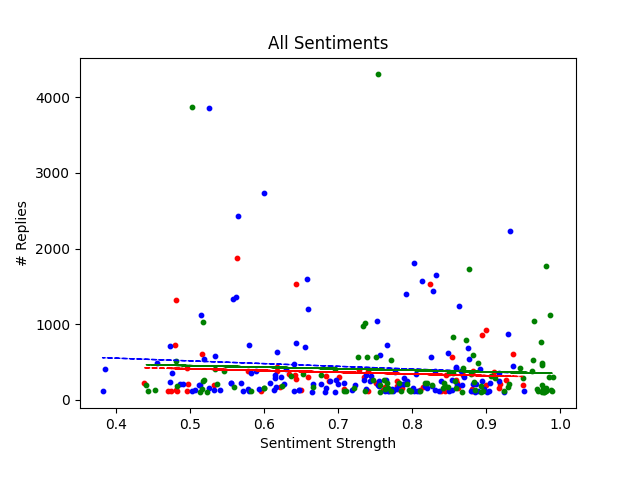
  
Negative Tweets

![negative replies.png](<attachment:negative replies.png>)

Neutral Tweets

![neutral replies.png](<attachment:neutral replies.png>)

Positive Tweets

![positive replies.png](<attachment:positive replies.png>)
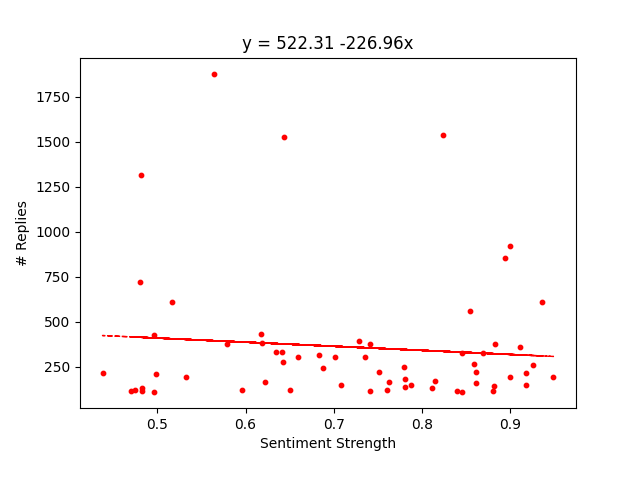
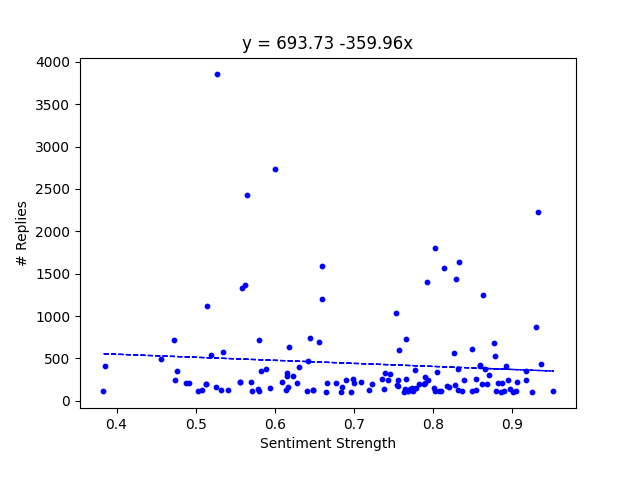
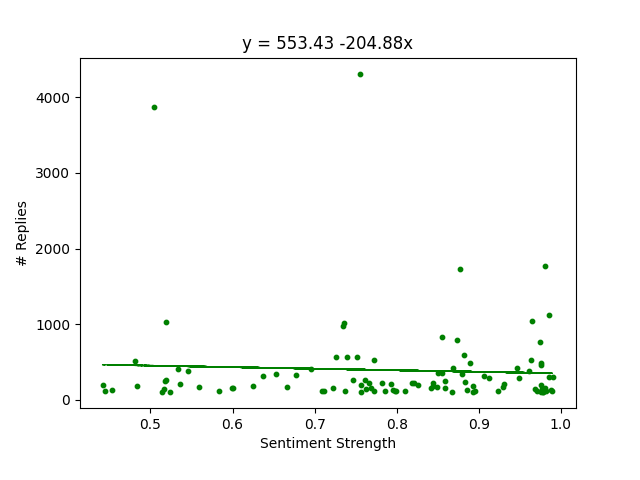

Unfortunately, it looked like there was relatively no correlation between sentiment strength/intensity and the amount of replies. I was thinking that more intensity would yield more replies. It was interesting to see that neutral tweets generally yielded more replies, however

### Machine Learning
Next, I tried to predict two things:
* Reply sentiment based on initial tweet variables
* Number of replies based on sentiment

Reply sentiment uses a random forest model while number of replies relies on a decision tree regressor

In [14]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from datetime import datetime
import matplotlib.pyplot as plt


def get_time_label(time_str):
    time_dict = {
        "early morning": "05:00:00-07:59:59",
        "morning": "08:00:00-11:59:59",
        "afternoon": "12:00:00-16:59:59",
        "evening": "17:00:00-20:59:59",
        "night": "21:00:00-04:59:59"
    }

    time = datetime.strptime(time_str, "%H:%M:%S").time()
    for label, time_range in time_dict.items():
        start_time_str, end_time_str = time_range.split("-")
        start_time = datetime.strptime(start_time_str, "%H:%M:%S").time()
        end_time = datetime.strptime(end_time_str, "%H:%M:%S").time()
        if (start_time <= time <= end_time) or (start_time > end_time and (start_time <= time or time <= end_time)):
            return label
    return "Unknown"

 
def random_forest_gen(df): # predict reply sentiment
    # base input and output data
    y = df['reply_sent']
    X = df.drop(columns=['reply_score', 'reply_sent', 'date', 'tweet', 'ai_reply', 'index'])
    
    # convert categorical to numerical
    le = preprocessing.LabelEncoder()
    cat_cols = ['source', 'time_of_day', 'month', 'tweet_sent']
    for col in cat_cols:
        X[col] = le.fit_transform(X[col])

    # fitting the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # prediction time
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)

    return rf

def tweet_reply_pred(df): # Regressor for num replies
    y = df['replies'].to_list()
    X = df.drop(columns=['date', 'tweet', 'ai_reply', 'index', 'source', 'time_of_day', 'month'])

    le = preprocessing.LabelEncoder()
    cat_cols = ['tweet_sent', 'reply_sent']
    for col in cat_cols:
        X[col] = le.fit_transform(X[col])

    score = 0
    while score < 0.4:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        regTree = tree.DecisionTreeRegressor(max_depth=5) # 5 is sweet spot
        regTree.fit(X_train, y_train)
        score = regTree.score(X_test, y_test)
    
    print(X_test)

    plt.figure(figsize=(90,30))
    tree.plot_tree(regTree, feature_names=X.columns, fontsize=25, filled=True)
    plt.savefig('ML/regtree.png')
    plt.close()

    return regTree, score

def main():    
    # random.seed(10)
    # read in data
    df = pd.read_csv("dfs/FINAL.csv")
    df = df[df.reply_sent.notnull()]
    df = df.reset_index()
    rf = random_forest_gen(df)
    df_2017 = df.iloc[:1009]
    tweet_reply_pred(df_2017)


### Deployment & Live Data
I used Streamlit for deployment and github actions to maintain live data. The streamlit files are found in the "streamlit" folder.

The github action workflow is as follows every 24h at 1:00 AM PST:
* Fetch new data from past 24h on twitter
* If new data,
    * Update tweet to raw tweets csv file
    * Run the following on new tweets
        * Sentiment analysis on tweet
        * Run BERT model to generate a base reply
        * Sentiment analysis on BERT reply
        * Add all to master CSV
    * Run EDA

The models are then all updated live on Streamlit

### Conclusions
It is very hard to model this kind of data. Perhaps it is the cult-like nature of the account I am analyzing or the overall unpredictability of twitter itself. Upon doing some research, it seems others have had trouble trying to predict the nature of social media. I believe the 'viral' nature of twitter is, at this point, impossible to fit a model to.